<a href="https://colab.research.google.com/github/Airaat/ml-study/blob/main/cnn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVHN CNN Classifier

In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Importing essential modules

In [2]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from matplotlib import pyplot as plt

## Loading dataset. Normalizing data to PyTorch format

In [3]:
def preprocess_data(examples):
  examples['image'] = [transform(image) for image in examples['image']]
  return examples


dataset = load_dataset("ufldl-stanford/svhn", "cropped_digits")

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = dataset.map(preprocess_data, batched=True)
train_ds, test_ds = dataset['train'], dataset['test']

train_ds.set_format(type='torch', columns=['image', 'label'])
test_ds.set_format(type='torch', columns=['image', 'label'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/136M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/47.0M [00:00<?, ?B/s]

extra-00000-of-00002.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

extra-00001-of-00002.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/73257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26032 [00:00<?, ? examples/s]

Generating extra split:   0%|          | 0/531131 [00:00<?, ? examples/s]

Map:   0%|          | 0/73257 [00:00<?, ? examples/s]

Map:   0%|          | 0/26032 [00:00<?, ? examples/s]

Map:   0%|          | 0/531131 [00:00<?, ? examples/s]

## Visualization of random samples from a dataset

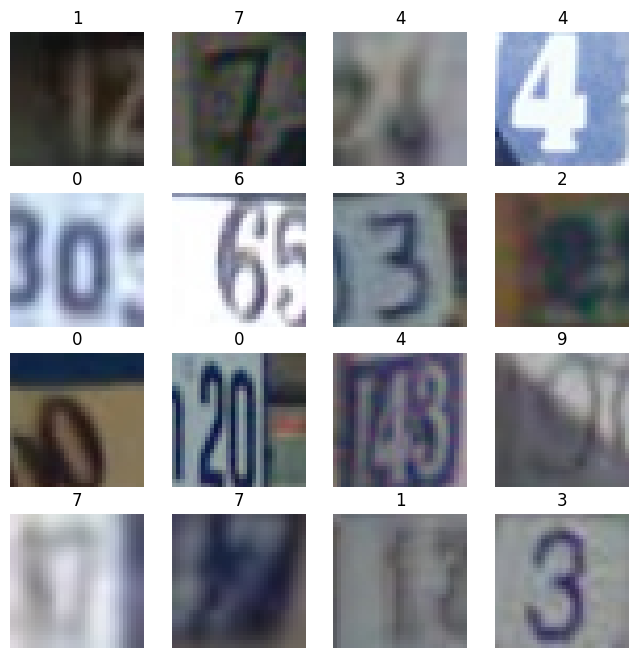

In [4]:
figure = plt.figure(figsize=(8,8))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  ind = random.randint(0, len(train_ds))
  sample = train_ds[ind]
  image, label = sample['image'], sample['label']

  # Transpose image to [H, W, C] for visualization
  image = image.permute(1, 2, 0)
  # Denormolize before visualization
  image = image * 0.5 + 0.5

  figure.add_subplot(rows, cols, i)
  plt.title(label.item())
  plt.axis('off')
  plt.imshow(image)

## Choosing available device for learning

In [5]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

device

'cuda'

## Architecture of model

In [6]:
class CNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(64 * 8 * 8, 512)
    self.fc2 = nn.Linear(512, 10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = CNNClassifier()
model.to(device)

CNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

## Declaration of core functions

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
  running_loss, correct = 0, 0
  size = len(dataloader.dataset)

  model.train()
  for batch in dataloader:
    X, y = batch['image'], batch['label']
    X, y = X.to(device), y.to(device)

    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()

    running_loss += loss.item() * len(X)
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  avg_loss = running_loss / size
  accuracy = correct / size
  return avg_loss, accuracy


def test_loop(dataloader, model, loss_fn):
  running_loss, correct = 0, 0
  size = len(dataloader.dataset)
  num_batches = len(dataloader)

  model.eval()
  with torch.no_grad():
    for batch in dataloader:
      X, y = batch['image'], batch['label']
      X, y = X.to(device), y.to(device)

      pred = model(X)
      running_loss += loss_fn(pred, y).item() * len(X)
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  avg_loss = running_loss / size
  accuracy = correct / size

  return avg_loss, accuracy


def plot_metrics(train_losses, val_losses, train_accs, val_accs):
  epochs = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 5))

  # Plot Loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label='Training Loss')
  plt.plot(epochs, val_losses, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plot Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accs, label='Training Accuracy')
  plt.plot(epochs, val_accs, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

## Setting hyperparams and creating DataLoaders

In [8]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

## Learning process. Visualisation of metrics

Epoch 1/20
Train Loss: 0.8812, Train Accuracy: 0.7211
Val Loss: 0.5201, Val Accuracy: 0.8545

Epoch 2/20
Train Loss: 0.4748, Train Accuracy: 0.8578
Val Loss: 0.4352, Val Accuracy: 0.8739

Epoch 3/20
Train Loss: 0.4015, Train Accuracy: 0.8796
Val Loss: 0.3990, Val Accuracy: 0.8839

Epoch 4/20
Train Loss: 0.3543, Train Accuracy: 0.8929
Val Loss: 0.3781, Val Accuracy: 0.8888

Epoch 5/20
Train Loss: 0.3225, Train Accuracy: 0.9025
Val Loss: 0.3606, Val Accuracy: 0.8970

Epoch 6/20
Train Loss: 0.2924, Train Accuracy: 0.9103
Val Loss: 0.3587, Val Accuracy: 0.8971

Epoch 7/20
Train Loss: 0.2707, Train Accuracy: 0.9170
Val Loss: 0.3642, Val Accuracy: 0.8969

Epoch 8/20
Train Loss: 0.2506, Train Accuracy: 0.9235
Val Loss: 0.3693, Val Accuracy: 0.9010

Epoch 9/20
Train Loss: 0.2329, Train Accuracy: 0.9268
Val Loss: 0.3773, Val Accuracy: 0.8986

Epoch 10/20
Train Loss: 0.2195, Train Accuracy: 0.9320
Val Loss: 0.3659, Val Accuracy: 0.9039

Epoch 11/20
Train Loss: 0.2020, Train Accuracy: 0.9371
Val 

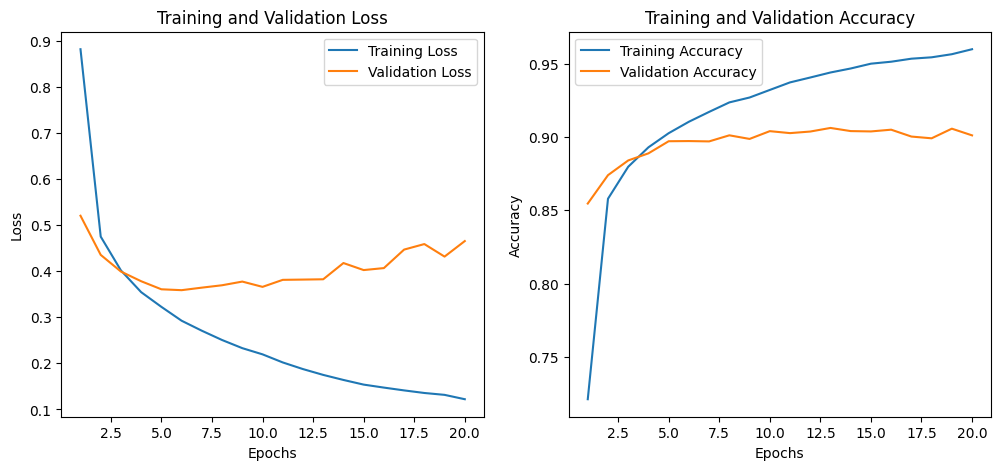

In [9]:
train_loss_history = []
train_acc_history = []

val_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
  print(f'Epoch {epoch+1}/{EPOCHS}')

  # Training
  train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_acc)

  # Validation
  val_loss, val_acc = test_loop(test_dataloader, model, loss_fn)
  val_loss_history.append(val_loss)
  val_acc_history.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}\n")

# Plot metrics
plot_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

## Manual validation of model's prediction

(-0.5, 31.5, 31.5, -0.5)

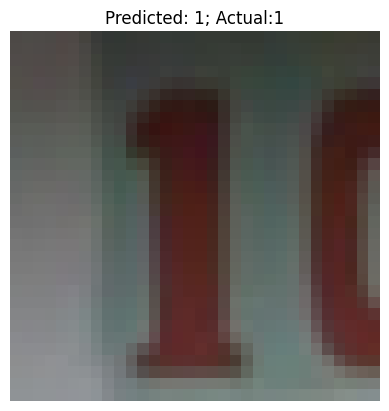

In [17]:
ind = random.randint(0, len(test_ds))
sample = test_ds[ind]
image, label = sample['image'], sample['label']

image, label = image.to(device), label.to(device)
pred = model(image.unsqueeze(0)).argmax(1).item()
# Transpose image to [H, W, C] for visualization
image = image.permute(1, 2, 0)
# Denormolize before visualization
image = image * 0.5 + 0.5

plt.title(f'Predicted: {pred}; Actual:{label.item()}')
plt.imshow(image.to('cpu'))
plt.axis('off')